# SNA Project - Adam Steciuk

# Part 1
## Data collection

I decided to create the dataset used for the project myself. I used the [Reddit API](https://www.reddit.com/dev/api/) and Python library wrapper called [Praw](https://praw.readthedocs.io/en/stable/index.html).

The data I wanted to collect was posts from different subreddits. My methodology for collecting the data was as follows:
1. Start with a queue with one subreddit.
2. Take the first subreddit from the queue.
3. Collect the top `NUM_POSTS_FROM_SUB` posts from the subreddit.
4. Disregard posts from users that have less than `MIN_TIMES_POSTED` posts in those `NUM_POSTS_FROM_SUB` posts.
5. For each user that is left, collect the top `NUM_POSTS_FROM_USER` posts from their profile and add the subreddits they are posted in to the queue if they weren't already visited.
6. Repeat steps 2-5 until the queue is empty or the subreddits that processed are further than `MAX_DEPTH` from the starting subreddit.

In order for the following code to work, you need to create a file called `reddit_secrets.py` in the same directory as this notebook. The file should contain the secrets you [got from reddit](https://www.reddit.com/prefs/apps/) when you created your app. The file should look like this:
```python
CLIENT_ID = "XXXXXXXXXXXXXXXXXXX"
CLIENT_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXX"
USER_AGENT = "your_app_name"
```

In [1]:
import praw
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np

# Import the secrets
from reddit_secrets import CLIENT_ID, CLIENT_SECRET, USER_AGENT

In [2]:
# Directory for raw data
DATA_DIRECTORY = 'data'
# Directory for processed data used in Cytoscape
NETWORKS_DIRECTORY = 'networks'

DATA_PATH = os.path.join(os.getcwd(), DATA_DIRECTORY)
NETWORKS_PATH = os.path.join(os.getcwd(), NETWORKS_DIRECTORY)

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

if not os.path.exists(NETWORKS_PATH):
    os.mkdir(NETWORKS_PATH)

The script below was running for about 8h on my machine before it encountered an internal server error from Reddit. Unfortunately it didn't even managed to process all subreddits at depth 2. I decided to create a method that would allow me to resume the process from the last subreddit that was processed. That also allows me to stop and resume the process on demand.

The script at the start tries to load the state from the pickle file. If it fails, it means that the file doesn't exist and the script starts from scratch. If it succeeds, it means that the file exists and the script resumes from the last subreddit that was processed.

In [3]:
# SCRIPT_SAVE_PATH = os.path.join(os.getcwd(), 'script_save.pkl')
# script_save = None
# try:
#     with open(SCRIPT_SAVE_PATH, 'rb') as f:
#         script_save = pickle.load(f)

#     print("Loaded script save. Resuming...")
#     print("NUM_POSTS_FROM_SUB:", script_save["NUM_POSTS_FROM_SUB"])
#     print("NUM_POSTS_OF_USER:", script_save["NUM_POSTS_OF_USER"])
#     print("MIN_TIMES_POSTED:", script_save["MIN_TIMES_POSTED"])
#     print("MAX_DEPTH:", script_save["MAX_DEPTH"])
#     print("Number of subreddits in queue:", len(script_save["sub_q"]))
#     print("Number of posts saved so far:", script_save["num_posts_saved"])
# except:
#     print("No script save found. Starting from scratch...")
    

# NUM_POSTS_FROM_SUB = 500 if script_save is None else script_save["NUM_POSTS_FROM_SUB"]
# NUM_POSTS_OF_USER = 5 if script_save is None else script_save["NUM_POSTS_OF_USER"]
# MIN_TIMES_POSTED = 2 if script_save is None else script_save["MIN_TIMES_POSTED"]
# MAX_DEPTH = 5 if script_save is None else script_save["MAX_DEPTH"]

# sub_q = ["programming"] if script_save is None else script_save["sub_q"]
# sub_depths = {sub_q[0]: 0} if script_save is None else script_save["sub_depths"]
# skipped_subs = [] if script_save is None else script_save["skipped_subs"]

# reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

# num_posts_saved = 0 if script_save is None else script_save["num_posts_saved"]

# # BFS; take the first subreddit from the queue.
# while len(sub_q) > 0 and (sub:=sub_q.pop(0)):
#     print("=========================================")
#     print(f"Processing '{sub}' on depth {sub_depths[sub]}")
#     print(f"Queue size: {len(sub_q)}")
#     print(f"Num posts saved so far: {num_posts_saved}")

#     posts = None
#     try:
#         # Download posts from the subreddit
#         posts = list(reddit.subreddit(sub).top(limit=NUM_POSTS_FROM_SUB, time_filter="all"))
#     except:
#         print(f"ERROR: Cannot access '{sub}'")
#         skipped_subs.append(sub)

#     if posts is not None:
#         if len(posts) < NUM_POSTS_FROM_SUB:
#             print(f"Only {len(posts)} posts found")

#         data_df = pd.DataFrame(
#             [[post.title, post.score, post.id, post.url, post.num_comments, post.created, post.author, post.upvote_ratio, post.permalink, post.subreddit, post.subreddit_subscribers, sub_depths[sub]] for post in posts],
#             columns=["title", "score", "id", "url", "num_comments", "created", "author", "upvote_ratio", "permalink", "subreddit", "subreddit_subscribers", "depth"],
#         )

#         # Filter out posts made by deleted users
#         data_df = data_df[data_df["author"].notna()]

#         # Keep only authors that posted more then MIN_TIMES_POSTED times
#         data_df["author_name"] = data_df["author"].apply(lambda x: x.name)
#         data_df = data_df.groupby("author_name").filter(lambda x: len(x) >= MIN_TIMES_POSTED)
#         data_df = data_df.drop(columns=["author_name"])

#         authors = data_df["author"].unique()
#         num_posts = len(data_df)
#         num_posts_saved += num_posts
#         print(f"Num posts after filtering out: {num_posts} from {len(authors)} authors")

#         # Check if we reached the max depth
#         if sub_depths[sub] >= MAX_DEPTH:
#             print("Max depth reached")
#         else:
#             for author in authors:
#                 try:
#                     # Try to get submissions of the author
#                     user_submissions = list(author.submissions.top(limit=NUM_POSTS_OF_USER, time_filter="all"))

#                     # Extract subreddits from top user submissions and add them to the queue
#                     for submission in user_submissions:
#                         sub_name = submission.subreddit.display_name
#                         if sub_name not in sub_depths:
#                             sub_q.append(sub_name)
#                             sub_depths[sub_name] = sub_depths[sub] + 1
#                 except:
#                     print(f"ERROR: User submissions are private for '{author}'")

#         # Save dataframe to csv
#         data_df.to_csv(f"{DATA_PATH}/posts_{sub}.csv", index=False)

#     # Save the script state to be able to resume in case of an error
#     script_save = {
#         "NUM_POSTS_FROM_SUB": NUM_POSTS_FROM_SUB,
#         "NUM_POSTS_OF_USER": NUM_POSTS_OF_USER,
#         "MIN_TIMES_POSTED": MIN_TIMES_POSTED,
#         "MAX_DEPTH": MAX_DEPTH,
#         "sub_q": sub_q,
#         "sub_depths": sub_depths,
#         "num_posts_saved": num_posts_saved,
#         "skipped_subs": skipped_subs,
#     }

#     with open(SCRIPT_SAVE_PATH, 'wb') as f:
#         pickle.dump(script_save, f)


I decided to stop the script manually after it collected around 150k posts even though it didn't reach the maximum depth. It took about 20h to collect that amount of data. I think that's enough for the project.

In [4]:
# Create the main dataframe
posts_df = pd.DataFrame()

# Load all the raw csv files into the main dataframe
for _root, _dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".csv"):
            posts_df = pd.concat([posts_df, pd.read_csv(os.path.join(DATA_PATH, file))], ignore_index=True)

display(posts_df.info())
display(posts_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149894 entries, 0 to 149893
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  149894 non-null  object 
 1   score                  149894 non-null  object 
 2   id                     149894 non-null  object 
 3   url                    149894 non-null  object 
 4   num_comments           149894 non-null  object 
 5   created                149894 non-null  float64
 6   author                 149894 non-null  object 
 7   upvote_ratio           149894 non-null  float64
 8   permalink              149894 non-null  object 
 9   subreddit              149894 non-null  object 
 10  subreddit_subscribers  149894 non-null  object 
 11  depth                  149894 non-null  object 
dtypes: float64(2), object(10)
memory usage: 13.7+ MB


None

,title,score,id,url,num_comments,created,author,upvote_ratio,permalink,subreddit,subreddit_subscribers,depth
41461,"Fox Business parts ways with Trish Regan, host...",15522,fqioyo,https://www.cnn.com/2020/03/27/media/trish-reg...,558,1.585396e+09,geoxol,0.95,/r/entertainment/comments/fqioyo/fox_business_...,entertainment,3762500,2
124949,Weedy Sea Dragon (Phyllopteryx taeniolatus) sp...,6099,kgen3a,https://gfycat.com/alienatedgrandiosebighornsheep,67,1.608407e+09,5_Frog_Margin,0.99,/r/TheDepthsBelow/comments/kgen3a/weedy_sea_dr...,TheDepthsBelow,1029703,3
133191,Edward Colston statue: Black Lives Matter prot...,6744,rwqghk,http://news.sky.com/story/edward-colston-statu...,2005,1.641399e+09,topotaul,0.89,/r/unitedkingdom/comments/rwqghk/edward_colsto...,unitedkingdom,1404690,2
1749,Lego campaign developed by Asawin Tejasakulsin...,1559,gc4ag6,https://i.redd.it/t3ufavmdwbw41.jpg,19,1.588415e+09,earthmoonsun,0.98,/r/AdPorn/comments/gc4ag6/lego_campaign_develo...,AdPorn,466917,2
93428,We’re fucking TERRIFIED you guys,4062,q16i55,https://i.imgur.com/JPPExEC.jpg,518,1.633358e+09,Rhymelikedocsuess,0.96,/r/ParlerWatch/comments/q16i55/were_fucking_te...,ParlerWatch,170734,2


The data I decided to collect has the following columns:
* `title` - title of the post
* `score` - score of the post
* `id` - id of the post
* `url` - url to content shared in the post (image, video, etc.)
* `num_comments` - number of comments on the post
* `created` - timestamp of the post creation
* `author` - author of the post
* `upvote_ratio` - ratio of upvotes to downvotes on the post
* `permalink` - url to the post
* `subreddit` - subreddit the post was posted in
* `subreddit_subscribers` - number of subscribers to the subreddit the post was posted in
* `depth` - depth of the subreddit from the starting subreddit

In [5]:
num_subredits = len(posts_df["subreddit"].unique())
num_authors = len(posts_df["author"].unique())
num_posts = len(posts_df)

print(f"Collected {num_posts} posts from {num_subredits} subreddits and {num_authors} authors")

Collected 149894 posts from 1030 subreddits and 32311 authors


subreddit
u_Unicornglitteryblood    500
u_SrGrafo                 500
u_pdwp90                  500
chloe                     500
pengu                     500
Andromeda321              499
netpolitics               493
CitizensClimateLobby      477
BottleNeck                475
ZadocPaet                 468
dtype: int64

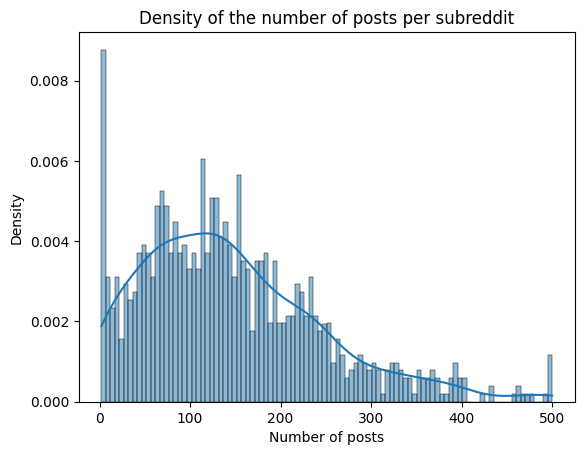

In [6]:
num_posts_per_sub = posts_df.groupby("subreddit").size().sort_values(ascending=False)
display(num_posts_per_sub.head(10))

# plot the density of the number of posts per subreddit
sns.histplot(num_posts_per_sub.values, stat="density", bins=100, kde=True)
plt.title("Density of the number of posts per subreddit")
plt.xlabel("Number of posts")
plt.ylabel("Density")
plt.show()


author
My_Memes_Will_Cure_U    63
Master1718              60
memezzer                49
KevlarYarmulke          47
5_Frog_Margin           45
GallowBoob              40
Scaulbylausis           36
kevinowdziej            33
icant-chooseone         29
AristonD                28
dtype: int64

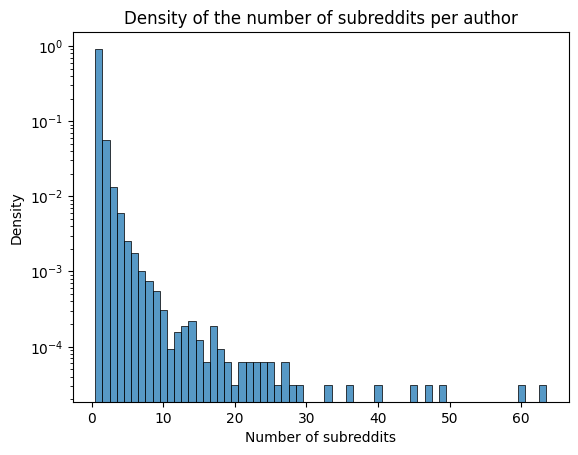

In [7]:
num_subs_per_author = posts_df.groupby(["author", "subreddit"]).size().groupby("author").size().sort_values(ascending=False)
display(num_subs_per_author.head(10))
# plot the density of the number of subreddits per author in log scale
sns.histplot(num_subs_per_author.values, discrete=True, stat="density", log_scale=(False, True))
plt.xlabel("Number of subreddits")
plt.title("Density of the number of subreddits per author")
plt.show()

## Bipartite network of subreddits and users

### Creation

First network I decided to create is a bipartite network of subreddits and users. There will be an edge between a subreddit and a user if there are at least `MIN_TIMES_POSTED` posts from that user in that subreddit. There is also an edge attribute `num_posts` that stores the number of posts from that user in that subreddit. It can be then used to calculate the weight of the edge if needed.

In [8]:
# Create a dataframe with all the author-subreddit pairs
author_sub_pairs = posts_df.groupby(["author", "subreddit"]).size().reset_index(name="num_posts")
display(author_sub_pairs.head(10))

# Save the author-subreddit pairs to a csv file that could be imported to Cytoscape
author_sub_pairs.to_csv(f"{NETWORKS_PATH}/author_sub_pairs.csv", index=False)

,author,subreddit,num_posts
0,--5-,india,2
1,--CreativeUsername,Physics,2
2,--Fatal--,homelab,2
3,--MVH--,Netherlands,4
4,--Speed--,logodesign,2
5,--UNFLAIRED--,carscirclejerk,2
6,--Yami_Marik--,WatchPeopleDieInside,3
7,--Yami_Marik--,holdmycosmo,2
8,-AMARYANA-,Awwducational,2
9,-AMARYANA-,Buddhism,7


Unfortunately clear visualization in Cytoscape is not possible due to the size of the network. The only layout that managed to finish calculating itself was the circular layout.

TODO: refresh the image and describe styling here. Move generation of sub data here.

![Bipartite network of subreddits and users](img/author_sub_pairs_full.png)


In [9]:
posts_df_filtered = posts_df[posts_df["depth"] <= 2]
print("Num of posts after 'depth <= 2':", len(posts_df_filtered))
posts_df_filtered = posts_df_filtered[posts_df_filtered["subreddit_subscribers"] >= 500000]
print("Num of posts after 'subreddit_subscribers >= 500000':", len(posts_df_filtered))

author_sub_pairs_filtered = posts_df_filtered.groupby(["author", "subreddit"]).size().reset_index(name="num_posts")
display(author_sub_pairs_filtered.head(10))

# Save the author-subreddit pairs to a csv file that could be imported to Cytoscape
author_sub_pairs_filtered.to_csv(f"{NETWORKS_PATH}/author_sub_pairs_filtered.csv", index=False)

Num of posts after 'depth <= 2': 121426
Num of posts after 'subreddit_subscribers >= 500000': 57800


,author,subreddit,num_posts
0,--5-,india,2
1,--CreativeUsername,Physics,2
2,--Fatal--,homelab,2
3,--Yami_Marik--,WatchPeopleDieInside,3
4,--Yami_Marik--,holdmycosmo,2
5,-AMARYANA-,Awwducational,2
6,-AMARYANA-,Buddhism,7
7,-AMARYANA-,Futurology,3
8,-AMARYANA-,spaceporn,2
9,-ARIDA-,photography,2


Because of the problem with visualization, I decided to create a smaller network. After filtrating out the posts from subreddits on depth 3 and above and posts in subreddits that have less than 500000 subscribers we are left with 57800 posts. That amount of Cytoscape is able to process.

The next thing I decided to do was to create a csv file which contains the nodes' attributes that could be used to style the network in Cytoscape. The file contains the following columns:
* `id` - id of the node
* `is_user` - boolean value indicating if the node is a subreddit or a user
* `subscribers` - number of subscribers of a subreddit if a node is a subreddit, otherwise it's `None`
* `total_score` - total score of all posts from a user if a node is a user, otherwise it's `None`

In [15]:
# Create a dataframe with subreddit subscribers. We have to use the mean and than round the values because
# data was collected from different times and the number of subscribers might have changed
sub_data = posts_df_filtered.groupby("subreddit").agg("subreddit_subscribers").mean().sort_values(ascending=False).reset_index()
sub_data["subreddit_subscribers"] = sub_data["subreddit_subscribers"].apply(lambda x: round(x))
# Change the name of the columns to `subscribers`
sub_data = sub_data.rename(columns={"subreddit_subscribers": "subscribers", "subreddit": "id"})
# Add other columns in order to merge the dataframes later
sub_data["is_user"] = False
display(sub_data.head(10))

# Save the dataframe to a csv file that could be imported to Cytoscape
sub_data.to_csv(f"{NETWORKS_PATH}/author_sub_pairs_filtered_sub_data.csv", index=False)

# Plot the distribution of the number of subscribers per subreddit
sns.histplot(sub_data["subscribers"], log_scale=(False, True), stat="density", bins=100)
plt.title("Distribution of the number of subscribers per subreddit")
plt.xlabel("Number of subscribers")
plt.ylabel("Density")
plt.show()

,id,subscribers,is_user
0,announcements,202719824,False
1,funny,48108476,False
2,AskReddit,40249936,False
3,gaming,36492322,False
4,aww,33655974,False
5,Music,32043294,False
6,worldnews,31254656,False
7,todayilearned,31041441,False
8,movies,30617572,False
9,pics,29880182,False


,id,total_score,is_user
0,beerbellybegone,24251827,True
1,My_Memes_Will_Cure_U,23451942,True
2,mvea,20047997,True
3,DaFunkJunkie,15101854,True
4,GallowBoob,13460347,True
5,Master1718,12168436,True
6,memezzer,10470602,True
7,unnaturalorder,10315964,True
8,kevinowdziej,8999849,True
9,relevantlife,8808124,True


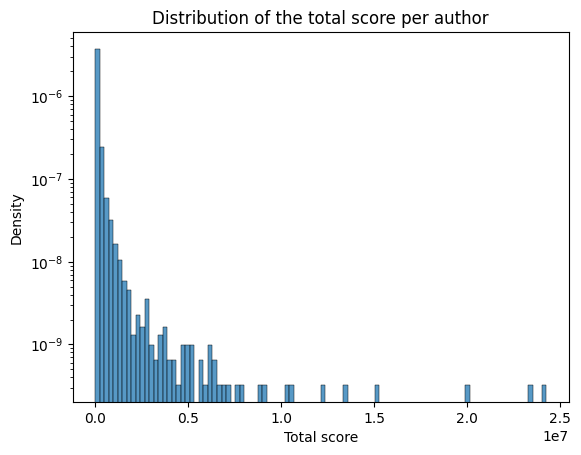

In [9]:
# Create a dataframe with author data and the total score of their posts
author_data = posts_df_filtered.groupby("author").agg("score").sum().sort_values(ascending=False).reset_index()
author_data = author_data.rename(columns={"score": "total_score", "author": "id"})
# Add other columns in order to merge the dataframes later
author_data["is_user"] = True
display(author_data.head(10))

# Save the dataframe to a csv file that could be imported to Cytoscape
author_data.to_csv(f"{NETWORKS_PATH}/author_sub_pairs_filtered_author_data.csv", index=False)

# Plot the distribution of the total score per author
sns.histplot(author_data["total_score"], log_scale=(False, True), stat="density", bins=100)
plt.title("Distribution of the total score per author")
plt.xlabel("Total score")
plt.ylabel("Density")
plt.show()

### Visualization and analysis

Below we cen see a visualization of the filtered bipartite network created in Cytoscape.
Styles used in the visualization:
* `is_user` - discrete mapping to colors: `blue` for `True` and `red` for `False`. (Red indicates that the node is a subreddit)
* `subscribers` - continuous mapping to sizes of the nodes.
* `num_posts` - continuous mapping to widths of the edges and their colors. (Darker and thicker edges indicate higher number of posts from a user in a subreddit)
* `total_score` - no mapping. I would like to map `total_score` to the size of the nodes if a node is a user and `subscribers` to the size of the nodes if a node is a subreddit but unfortunately I didn't find a way to do that.

![Bipartite network of filtered subreddits and users](img/author_sub_pairs_filter.png)

Results of the analysis for both networks:

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;}
.tg td{background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-yad6{background-color:#D2E4FC;border-color:#9abad9;text-align:left;vertical-align:top}
.tg .tg-hmp3{background-color:#D2E4FC;text-align:left;vertical-align:top}
.tg .tg-rx1i{border-color:#9abad9;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-6578{border-color:#9abad9;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-rx1i" colspan="2"></th>
    <th class="tg-rx1i"># components</th>
    <th class="tg-rx1i"># nodes</th>
    <th class="tg-0lax"># users</th>
    <th class="tg-0lax"># subs</th>
    <th class="tg-rx1i"># edges</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-yad6" colspan="2">Unfiltered network</td>
    <td class="tg-yad6">51</td>
    <td class="tg-yad6">33 341</td>
    <td class="tg-hmp3">32 311</td>
    <td class="tg-hmp3">1 030</td>
    <td class="tg-yad6">38 054</td>
  </tr>
  <tr>
    <td class="tg-6578">-</td>
    <td class="tg-rx1i">Largest component</td>
    <td class="tg-rx1i">1</td>
    <td class="tg-rx1i">31 920</td>
    <td class="tg-0lax">30 942</td>
    <td class="tg-0lax">978</td>
    <td class="tg-rx1i">36 691</td>
  </tr>
  <tr>
    <td class="tg-yad6" colspan="2">Filtered network</td>
    <td class="tg-yad6">38</td>
    <td class="tg-yad6">13 165</td>
    <td class="tg-hmp3">12 706</td>
    <td class="tg-hmp3">459</td>
    <td class="tg-yad6">15 672</td>
  </tr>
  <tr>
    <td class="tg-6578">-</td>
    <td class="tg-rx1i">Largest component</td>
    <td class="tg-rx1i">1</td>
    <td class="tg-rx1i">12 506</td>
    <td class="tg-0lax">12 087</td>
    <td class="tg-0lax">419</td>
    <td class="tg-rx1i">15 050</td>
  </tr>
</tbody>
</table>

Other metrics, such as average degree, average clustering coefficient, average path length, etc. don't make much sens for bipartite networks and won't be analyzed here. I'll focus on them in the next section.

In [29]:
posts_df.head()

,title,score,id,url,num_comments,created,author,upvote_ratio,permalink,subreddit,subreddit_subscribers,author_name
0,anime_irl,61838,v5pw6o,https://i.redd.it/uh2vc0cy4w391.gif,535,1.654473e+09,NekoWafers,0.92,/r/anime_irl/comments/v5pw6o/anime_irl/,anime_irl,2680226,NekoWafers
1,anime_irl,48804,rlbhh5,https://v.redd.it/wqlc6vm6dv681,684,1.640081e+09,StazCherryBlood,0.96,/r/anime_irl/comments/rlbhh5/anime_irl/,anime_irl,2680226,StazCherryBlood
2,anime_irl,38093,pcxzf1,https://v.redd.it/vwyw14czbzj71,419,1.630105e+09,NekoWafers,0.94,/r/anime_irl/comments/pcxzf1/anime_irl/,anime_irl,2680226,NekoWafers
3,anime_irl,36736,v7xkmk,https://i.redd.it/ztianvtf6g491.gif,405,1.654716e+09,Levi-7536,0.95,/r/anime_irl/comments/v7xkmk/anime_irl/,anime_irl,2680226,Levi-7536
4,anime_irl,35174,vkamt7,https://v.redd.it/h4g5hyzvbq791,579,1.656146e+09,Hot_Fan_,0.94,/r/anime_irl/comments/vkamt7/anime_irl/,anime_irl,2680226,Hot_Fan_
